# TCC: NER


## Train Spacy

### Imports

In [1]:
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 4.9 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [2]:
!python -m spacy download pt_core_news_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 568.2 MB 10 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


In [3]:
!pip install plac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import plac
import spacy
import random
import sklearn
import numpy as np
import pandas as pd
import pt_core_news_lg
import pt_core_news_sm
import matplotlib.pyplot as plt

from pathlib import Path
from __future__ import unicode_literals, print_function

### Dados de treinamento:

- Carregamento dos dados anotados.
- Formatação dos dados para treinamento no Spacy.

In [30]:
data = pd.read_json('output_anotacoes.json')
data

,id,text,label
0,1,"ESTADO DO ACRE DECRETO Nº 9.693, DE 27 DE JULH...",[]
1,2,"ESTADO DO ACRE DECRETO Nº 9.695, DE 28 DE JULH...",[]
2,3,"ESTADO DO ACRE DECRETO Nº 9.696, DE 28 DE JULH...",[]
3,4,"ESTADO DO ACRE DECRETO Nº 9.354, DE 29 DE JUNH...",[]
4,5,"ESTADO DO ACRE DECRETO Nº 9.558, DE 23 DE JULH...",[]
...,...,...,...
6494,6495,ESTADO ACRE PREFEITURA MUNICIPAL DE CRUZEIRO D...,"[[12, 51, ENTE], [71, 99, IDENTIFICACAO], [107..."
6495,6496,ESTADO ACRE PREFEITURA MUNICIPAL DE RODRIGUES ...,"[[12, 51, ENTE], [76, 108, IDENTIFICACAO], [11..."
6496,6497,ESTADO ACRE PREFEITURA MUNICIPAL DE RODRIGUES ...,"[[12, 51, ENTE], [71, 103, IDENTIFICACAO], [11..."
6497,6498,ESTADO ACRE PREFEITURA MUNICIPAL DE RODRIGUES ...,"[[12, 50, ENTE], [71, 103, IDENTIFICACAO], [11..."


#### Preparação dos dados: 

In [31]:
def labels_2_entities(labels):
    result = []
    for label in labels:
        # if label[2] not in ['ENTE', 'ORGAO']:
        result.append((label[0], label[1], label[2]))
    return result


def data_2_training(data):
    result = []
    for element in data:
        if len(element[2]) > 0:
            result.append(
                (element[1], {
                    'entities': labels_2_entities(element[2])
                })
            )
    return result

In [32]:
TRAIN_DATA = data_2_training(data.values.tolist())
TRAIN_DATA[1]

('GOVERNO DO ESTADO DO ACRE SECRETARIA DE INDÚSTRIA, CIÊNCIA E TECNOLOGIA - SEICT AVISO DE LICITAÇÃO PREGÃO ELETRÔNICO PELO SISTEMA DE REGISTRO DE PREÇOS  N 215/2021 – SESACRE Objeto: Contratação de empresa para realização de serviços de manutenção preventiva, corretiva e calibração com fornecimento de peças e  acessórios, dos Equipamentos de Cozinha, a fim de atender as necessidades das Unidades de Saúde, no âmbito da Secretaria de Estado de  Saúde – SESACRE. Fonte de Recursos: 100 (Recursos Próprios – Ordinários) e 400 (Transferências de Recursos do Sistema Único de Saúde – SUS de origem  da União). Propostas: Serão recebidas até às 10h30min (horário de Brasília) do dia  13 de Agosto de 2021, quando terá início a disputa de preços no sistema  eletrônico: site www.comprasnet.gov.br. Edital e Informações: O edital está à disposição, através dos sites: www. ac.gov.br, www.licitacao.ac.gov.br e www.comprasnet.gov.br. Rio Branco-AC, 30 de Julho de 2021. ASS Mário Jorge Moraes  ',
 {'entit

### Pré-processamento e Treinamento:

###### Pré-processamento:

In [33]:
TRAIN_DATA[664]

('AVISO DE LICITAÇÃO EDITAL DE LICITAÇÃO 002/2021 PREGÃO SRP Nº 002/2021 PREGÃO ELETRÔNICO OBJETO: Aquisição de veículos, tipo caminhonete, zero quilômetro, emplacados dentro do Padrão MERCOSUL, no Departamento de Trânsito  do Estado do Acre – DETRAN/AC, em nome da Defensoria Pública do  Estado do Acre, e com garantia do fabricante, visando atender à necessidade de renovação da frota da DPE/AC ABERTURA: 11 de novembro de 2021, às 10:30 horas LOCAL: www.comprasnet.gov.br Para todas as referências de tempo será utilizado o horário de Brasília  UASG 459931   RAPHAEL BATISTA DA SILVA Pregoeiro da DPE/AC Portaria nº. 097/GAB/DPE-AC ',
 {'entities': [(48, 70, 'IDENTIFICACAO'),
   (97, 331, 'OBJETO'),
   (264, 293, 'ENTE'),
   (264, 293, 'ORGAO')]})

In [34]:
len(TRAIN_DATA)

860

In [35]:
def verify_interval(s2, e2):
    if s2 <= e2:
        return True
    return False


result = []
for i in range(0, len(TRAIN_DATA)):
    entities = TRAIN_DATA[i][1]['entities']
    if len(entities) > 1:
        entis = []
        for index in range(1, len(entities)):
            # print(entities[index])
            added = False
            for j in range(index - 1, -1, -1):
                if verify_interval(entities[index][0], entities[j][1]):
                    # print(data[0])
                    # print(data[1])
                    # print("------")
                    result.append(
                        (TRAIN_DATA[i][0], {"entities": [entities[index]]})
                    )
                    if not added:
                        entis.append(entities[index])
                        added = True
        for enti in entis:
            TRAIN_DATA[i][1]['entities'].remove(enti)


In [36]:
result[0:2]

[('AVISO DE LICITAÇÃO SHOPPING Nº 012/2021 – BIRD/SEPLAG/SESACRE Objeto: Contratação de empresa de engenharia para execução dos  serviços de construção dos Abrigos de resíduos sólidos da unidade de  saúde de Santa Rosa do Purus. Fonte de Recurso: 500 – BIRD. Edital e Informações: O edital está à disposição nos sites www.ac.gov. br e www.licitacao.ac.gov.br. Data da Abertura: 02/09/2021 às 10h, conforme preâmbulo no Edital. Rio Branco-AC, 25 de Agosto de 2021.   ASS Saluana Bonfim do Nascimento  CAR Presidente da Comissão ',
  {'entities': [(47, 53, 'ENTE')]}),
 ('AVISO DE LICITAÇÃO SHOPPING Nº 012/2021 – BIRD/SEPLAG/SESACRE Objeto: Contratação de empresa de engenharia para execução dos  serviços de construção dos Abrigos de resíduos sólidos da unidade de  saúde de Santa Rosa do Purus. Fonte de Recurso: 500 – BIRD. Edital e Informações: O edital está à disposição nos sites www.ac.gov. br e www.licitacao.ac.gov.br. Data da Abertura: 02/09/2021 às 10h, conforme preâmbulo no Edital. Rio Br

In [39]:
len(TRAIN_DATA)

1053

In [38]:
TRAIN_DATA.extend(result)

###### Treino:

In [ ]:
# model = "pt_core_news_sm"

# if model is not None:
#     nlp = pt_core_news_sm.load()
#     print("Loaded model '%s'" % model)
# else:
#     nlp = spacy.blank('pt')  
#     print("Created blank 'pt' model")

# if 'ner' not in nlp.pipe_names:
#     ner = nlp.create_pipe('ner')
#     nlp.add_pipe(ner, last=True)
# else:
#     ner = nlp.get_pipe('ner')

Loaded model 'pt_core_news_sm'


In [40]:
model = None

if model is not None:
    nlp = pt_core_news_sm.load()
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('pt')  
    print("Created blank 'pt' model")

if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe('ner', last=True)
else:
    ner = nlp.get_pipe('ner')

Created blank 'pt' model


In [41]:
from sklearn.model_selection import train_test_split

training_dataset, test_dataset = train_test_split(TRAIN_DATA, test_size=0.05, shuffle=True, random_state=13)

In [42]:
len(training_dataset)

1000

In [43]:
len(test_dataset)

53

In [44]:
model = None
output_dir=Path("./")
n_iter=100

In [48]:
import string
from spacy.training.example import Example

for _, annotations in training_dataset:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

list_losses = []
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
    spacy.util.fix_random_seed()
    # optimizer = nlp.create_optimizer()
    for itn in range(n_iter):
        random.shuffle(training_dataset)
        losses = {}

        for batch in spacy.util.minibatch(training_dataset, size=1):
            for text, annotations in batch:
                # create Example
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                # Update the model
                nlp.update([example], drop=0.3, sgd=optimizer, losses=losses)
        print("Terminou: ", itn)
        print(losses)
        list_losses.append(losses.get("ner"))


list_losses = np.array(list_losses)

/usr/local/lib/python3.7/dist-packages/spacy/training/iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "ESTADO DO ACRE PREFEITURA MUNICIPAL DE PORTO ACRE ..." with entities "[(15, 49, 'ENTE'), (109, 138, 'IDENTIFICACAO'), (1...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/usr/local/lib/python3.7/dist-packages/spacy/training/iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "ESTADO DO ACRE MUNICÍPIO DE XAPURI   AVISO DE LICI..." with entities "[(15, 34, 'ENTE'), (249, 281, 'IDENTIFICACAO'), (3...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/usr/local/lib/python3

Terminou:  0
{'ner': 8355.99767404257}
Terminou:  1
{'ner': 3233.9379090903394}
Terminou:  2
{'ner': 2966.874569019922}
Terminou:  3
{'ner': 2624.6217588808922}
Terminou:  4
{'ner': 2569.79039096665}
Terminou:  5
{'ner': 2496.760172214714}
Terminou:  6
{'ner': 2353.9132247998127}
Terminou:  7
{'ner': 2409.65606262809}
Terminou:  8
{'ner': 2449.0278929942633}
Terminou:  9
{'ner': 2313.2568167131135}
Terminou:  10
{'ner': 2304.748072803609}
Terminou:  11
{'ner': 2306.696631370842}
Terminou:  12
{'ner': 2290.039374136961}
Terminou:  13
{'ner': 2294.9763131881427}
Terminou:  14
{'ner': 2310.6589865588844}
Terminou:  15
{'ner': 2276.8781879951634}
Terminou:  16
{'ner': 2316.646998973065}
Terminou:  17
{'ner': 2418.817160536363}
Terminou:  18
{'ner': 2236.4582428270164}
Terminou:  19
{'ner': 2222.5478233916565}
Terminou:  20
{'ner': 2160.5798958888017}
Terminou:  21
{'ner': 2238.1020903454632}
Terminou:  22
{'ner': 2234.7579323760997}
Terminou:  23
{'ner': 2153.2610975063694}
Terminou:  24
{

Text(0, 0.5, 'Erro')

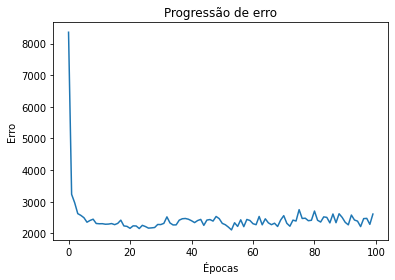

In [49]:
plt.plot(list_losses)
plt.title("Progressão de erro")
plt.xlabel("Épocas")
plt.ylabel("Erro")

In [50]:
def format_ent(text, ents):
    result = []
    for ent in ents:
        result.append((text[ent[0]: ent[1]], ent[2]))
    return result

In [51]:
for text, ents_true in test_dataset[0:10]:
    doc = nlp(text)
    print('Entities: ', [(ent.text, ent.label_) for ent in doc.ents])
    print('Ent.true: ', format_ent(text, ents_true['entities']))
    print("-----------")

Entities:  [('PREGÃO PRESENCIAL Nº 003/2021', 'IDENTIFICACAO'), ('Contratação de empresa para aquisição de veículo utilitário tipo caminhonete', 'OBJETO')]
Ent.true:  [('PREGÃO PRESENCIAL Nº 003/2021', 'IDENTIFICACAO'), ('Contratação de empresa para aquisição de veículo utilitário tipo caminhonete', 'OBJETO'), ('Câmara Municipal de Feijó', 'ORGAO'), ('Câmara Municipal de Feijó', 'ENTE')]
-----------
Entities:  [('PREFEITURA MUNICIPAL DE RIO BRANCO', 'ENTE'), ('PREGÃO ELETRÔNICO SRP Nº 079/2021', 'IDENTIFICACAO'), ('Aquisição de equipamentos permanentes (eletrônicos de áudio e mídia e musicais)', 'OBJETO'), ('Fundação Municipal de Cultura, Esporte e Lazer Garibaldi Brasil', 'ORGAO')]
Ent.true:  [('PREFEITURA MUNICIPAL DE RIO BRANCO', 'ENTE'), ('PREGÃO ELETRÔNICO SRP Nº 079/2021', 'IDENTIFICACAO'), ('Aquisição de equipamentos permanentes (eletrônicos de áudio e mídia e musicais)', 'OBJETO'), ('Fundação Municipal de Cultura, Esporte e Lazer Garibaldi Brasil', 'ORGAO')]
-----------
Entitie

In [52]:
def get_entity_options(random_colors=False):
    """
    generating color options for visualizing the named entities
    """
    def color_generator(number_of_colors):
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
        return color

    entities = ["IDENTIFICACAO", "OBJETO", "ENTE", "ORGAO"]

    colors = {"ENT":"#E8DAEF"}
    
    entities_cat_1 = {"IDENTIFICACAO":"#F9E79F",}
    entities_cat_2 = {"OBJETO":"#82E0AA",}
    entities_cat_3 = {"ENTE":"#D7BDE2",}
    entities_cat_4 = {"ORGAO":"#D7XCE3"}

    entities_cats = [entities_cat_1, entities_cat_2, entities_cat_3, entities_cat_4]
    for item in entities_cats:
        colors = {**colors, **item}
    
    options = {"ents": entities, "colors": colors, "collapse_punct": True}
    
    return options

In [53]:
for t in test_dataset[10:20]:
  text = nlp(t[0])

  options = get_entity_options()
  spacy.displacy.parse_ents(text).get("ents")
  spacy.displacy.render(text, style='ent', options=options, jupyter=True)
  print("\n")

###### Salvando modelo:

In [ ]:
output_dir = Path('./teste1')

In [ ]:
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

Saved model to teste1


In [ ]:
!unzip ./modelo_ner_com_ente_orgao.zip

Archive:  ./modelo_ner_com_ente_orgao.zip
  inflating: teste1/config.cfg       
  inflating: teste1/tokenizer        
   creating: teste1/ner/
  inflating: teste1/ner/cfg          
  inflating: teste1/ner/model        
  inflating: teste1/ner/moves        
   creating: teste1/vocab/
 extracting: teste1/vocab/lookups.bin  
  inflating: teste1/vocab/vectors    
 extracting: teste1/vocab/key2row    
  inflating: teste1/vocab/strings.json  
 extracting: teste1/vocab/vectors.cfg  
  inflating: teste1/meta.json        


In [ ]:
print("Loading from", output_dir)
nlp2 = spacy.load(output_dir)

Loading from teste1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "./modelo_ner_pretrainer_pt.zip" "/content/drive/MyDrive/my_tcc/my_modelo_ner_pretrainer_pt.zip"

In [54]:
doc = nlp("GOVERNO DO ESTADO DO ACRE SECRETARIA DE IND\u00daSTRIA, CI\u00caNCIA E TECNOLOGIA - SEICT AVISO DE LICITA\u00c7\u00c3O PREG\u00c3O ELETR\u00d4NICO PELO SISTEMA DE REGISTRO DE PRE\u00c7OS  N 137/2020 \u2013 DETRAN Objeto: Contrata\u00e7\u00e3o de pessoa jur\u00eddica para aquisi\u00e7\u00e3o de materiais de consumo tais como: carimbos, almofadas e refis de almofada para carimbos,  bem como servi\u00e7os de plotagem, plastifica\u00e7\u00e3o, encaderna\u00e7\u00f5es e confec\u00e7\u00e3o de c\u00f3pias de chaves para portas, em atendimento as necessidades de  diversos setores deste Departamento Estadual de Tr\u00e2nsito. Fonte de Recursos: 700 \u2013 Recurso Pr\u00f3prio. Propostas: Ser\u00e3o recebidas at\u00e9 \u00e0s 10h30min (hor\u00e1rio de Bras\u00edlia) do dia  16 de Agosto de 2021, quando ter\u00e1 in\u00edcio a disputa de pre\u00e7os no sistema  eletr\u00f4nico: site www.comprasnet.gov.br. Edital e Informa\u00e7\u00f5es: O edital est\u00e1 \u00e0 disposi\u00e7\u00e3o, atrav\u00e9s dos sites: www. ac.gov.br, www.licitacao.ac.gov.br e www.comprasnet.gov.br. Rio Branco-AC, 02 de Agosto de 2021. ASS Adriana Vasconcelos da Silva CAR Pregoeira ")
for ent in doc.ents:
  print(ent, ent.label_)

SECRETARIA DE INDÚSTRIA, CIÊNCIA E TECNOLOGIA - SEICT ENTE
PREGÃO ELETRÔNICO PELO SISTEMA DE REGISTRO DE PREÇOS  N 137/2020 – DETRAN IDENTIFICACAO
Contratação de pessoa jurídica para aquisição de materiais de consumo tais como: carimbos, almofadas e refis de almofada para carimbos,  bem como serviços de plotagem, plastificação, encadernações e confecção de cópias de chaves para portas OBJETO
Departamento Estadual de Trânsito ORGAO
